# Feature Creation

### All Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from word_list.basic import politics1, politics2
from word_list.basic import business
from statsmodels.tsa.stattools import adfuller

## Organizing Google trends data

,act,bank,blacklist,bubble,business,carolina,case,cash,ceo,college,committee,community,companies,corporation,council,county,court,democratic,development,district,dividend,economic,elected,election,elections,energy,federal,financial,firm,founded,gain,georgia,global,government,governor,illinois,inc,industry,investment,judge,justice,kentucky,law,legal,ltd,management,market,marketing,massachusetts,media,members,million,minister,ministry,missouri,movement,ohio,party,pennsylvania,police,political,president,products,project,representatives,republican,return,revenue,rights,seats,secretary,security,senate,served,service,services,social,society,stats,stocks,technology,tennessee,texas,transaction,union,vermont,virginia,voters,votes,war,washington,william,wisconsin,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,14.0,52.0,1.0,5.0,46.0,55.0,31.0,10.0,0.0,63.0,4.0,49.0,21.0,14.0,9.0,52.0,20.0,5.0,10.0,22.0,1.0,4.0,0.0,5.0,1.0,13.0,33.0,16.0,1.0,1.0,6.0,43.0,11.0,17.0,2.0,37.0,28.0,4.0,7.0,4.0,6.0,16.0,35.0,14.0,4.0,25.0,26.0,9.0,27.0,45.0,7.0,6.0,0.0,3.0,26.0,2.0,58.0,35.0,28.0,26.0,6.0,8.0,26.0,25.0,2.0,4.0,30.0,3.0,7.0,6.0,3.0,31.0,1.0,1.0,76.0,32.0,19.0,31.0,8.0,8.0,20.0,20.0,66.0,1.0,44.0,24.0,53.0,1.0,1.0,36.0,60.0,28.0,36.0,80.0
2004-01-02,17.0,90.0,2.0,3.0,66.0,49.0,26.0,9.0,1.0,81.0,3.0,63.0,18.0,20.0,11.0,82.0,33.0,5.0,17.0,32.0,1.0,5.0,0.0,3.0,2.0,17.0,47.0,31.0,5.0,1.0,4.0,48.0,16.0,26.0,3.0,53.0,35.0,10.0,10.0,3.0,6.0,15.0,52.0,14.0,7.0,36.0,27.0,13.0,27.0,41.0,6.0,4.0,2.0,3.0,24.0,4.0,63.0,33.0,32.0,30.0,10.0,11.0,36.0,28.0,1.0,3.0,25.0,8.0,10.0,6.0,10.0,43.0,3.0,1.0,93.0,59.0,24.0,33.0,4.0,10.0,26.0,18.0,77.0,1.0,54.0,16.0,61.0,1.0,1.0,41.0,80.0,32.0,36.0,91.0
2004-01-03,16.0,67.0,1.0,6.0,51.0,40.0,27.0,9.0,3.0,70.0,3.0,49.0,16.0,13.0,9.0,69.0,23.0,5.0,16.0,26.0,2.0,2.0,1.0,3.0,1.0,12.0,34.0,14.0,3.0,1.0,8.0,41.0,14.0,19.0,2.0,44.0,23.0,10.0,7.0,3.0,7.0,15.0,43.0,13.0,8.0,27.0,32.0,8.0,27.0,40.0,8.0,3.0,2.0,5.0,23.0,6.0,65.0,36.0,27.0,26.0,7.0,10.0,31.0,27.0,2.0,4.0,26.0,7.0,8.0,5.0,5.0,28.0,2.0,1.0,70.0,33.0,22.0,30.0,6.0,8.0,22.0,17.0,67.0,2.0,43.0,14.0,55.0,1.0,1.0,51.0,72.0,29.0,34.0,75.0
2004-01-04,18.0,57.0,0.0,6.0,51.0,51.0,26.0,10.0,1.0,68.0,3.0,50.0,18.0,13.0,10.0,67.0,27.0,8.0,19.0,31.0,2.0,5.0,1.0,4.0,1.0,18.0,29.0,17.0,4.0,1.0,4.0,46.0,12.0,21.0,2.0,43.0,28.0,9.0,8.0,3.0,8.0,14.0,46.0,11.0,5.0,26.0,25.0,9.0,26.0,43.0,6.0,5.0,3.0,3.0,20.0,3.0,60.0,41.0,26.0,32.0,10.0,10.0,27.0,31.0,2.0,5.0,24.0,7.0,14.0,6.0,4.0,30.0,2.0,1.0,79.0,38.0,21.0,32.0,8.0,6.0,24.0,21.0,70.0,0.0,37.0,16.0,56.0,1.0,1.0,60.0,68.0,34.0,29.0,85.0
2004-01-05,21.0,50.0,0.0,3.0,52.0,47.0,26.0,10.0,4.0,100.0,4.0,88.0,19.0,10.0,11.0,71.0,28.0,9.0,19.0,58.0,2.0,6.0,2.0,5.0,2.0,11.0,25.0,18.0,8.0,3.0,5.0,38.0,10.0,25.0,5.0,36.0,30.0,7.0,10.0,5.0,5.0,14.0,52.0,16.0,4.0,36.0,22.0,13.0,24.0,43.0,5.0,4.0,3.0,6.0,20.0,6.0,49.0,30.0,21.0,30.0,7.0,13.0,29.0,28.0,2.0,6.0,22.0,5.0,12.0,4.0,3.0,35.0,2.0,2.0,70.0,44.0,17.0,33.0,6.0,6.0,21.0,19.0,66.0,2.0,31.0,12.0,57.0,2.0,2.0,64.0,67.0,39.0,30.0,70.0


#### shape = (6061, 94)

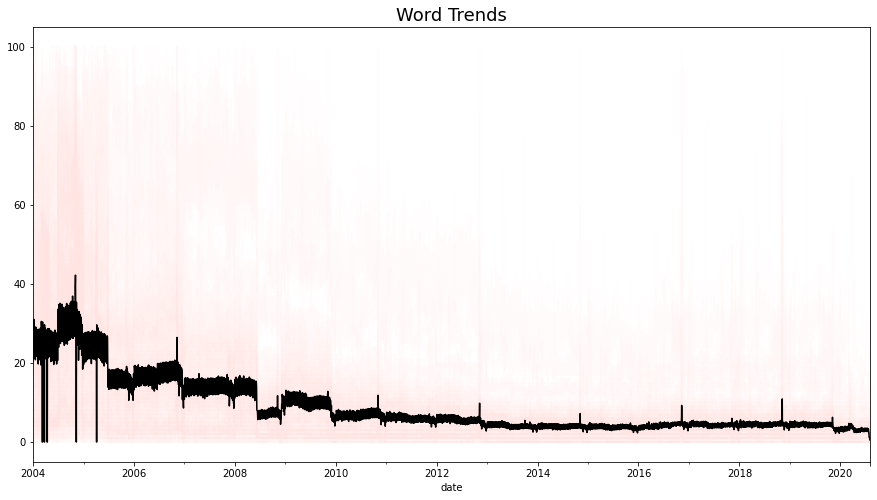

In [6]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_list = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_list.append(ts)

trends = pd.concat(trends_list,1)
trends = trends.fillna(0.0)
huang = ["cash", "bubble", "return", "stocks",
         "gain", "transaction", "dividend",
         "revenue", "war", "society"]
selected_words = politics1 + politics2 + business + huang
selected_words = list(set(selected_words))
selected_words.sort()
selected_words.remove("notability")
trends = trends[selected_words]

display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

fig, ax = plt.subplots(figsize=(15,8))
trends.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trends", fontsize=18);

## Creating Features

Let ${S^{w}}_t$ be the search interest in the word $w$ at day $t$, we define the word feature ${D^{w}}_t$ as the first difference:

\begin{equation}
{D^{w}}_{t} = {S^{w}}_t - {S^{w}}_{t-1}.
\end{equation}

In [7]:
alpha = 0.01
diff_param = 1
obs = []
for c in tqdm(trends.columns):
    s = trends[c].diff(diff_param).dropna().values
    result_adfuller = adfuller(s)
    p_value = result_adfuller[1]
    obs.append((c, p_value, p_value < alpha))
    
obs = pd.DataFrame(obs, columns=["column","p_value","test"])
assert np.all(obs["test"])

100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


In [8]:
trends = trends.diff(1).dropna()
trends.head(5)

,act,bank,blacklist,bubble,business,carolina,case,cash,ceo,college,...,union,vermont,virginia,voters,votes,war,washington,william,wisconsin,york
date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,3.0,38.0,1.0,-2.0,20.0,-6.0,-5.0,-1.0,1.0,18.0,...,10.0,-8.0,8.0,0.0,0.0,5.0,20.0,4.0,0.0,11.0
2004-01-03,-1.0,-23.0,-1.0,3.0,-15.0,-9.0,1.0,0.0,2.0,-11.0,...,-11.0,-2.0,-6.0,0.0,0.0,10.0,-8.0,-3.0,-2.0,-16.0
2004-01-04,2.0,-10.0,-1.0,0.0,0.0,11.0,-1.0,1.0,-2.0,-2.0,...,-6.0,2.0,1.0,0.0,0.0,9.0,-4.0,5.0,-5.0,10.0
2004-01-05,3.0,-7.0,0.0,-3.0,1.0,-4.0,0.0,0.0,3.0,32.0,...,-6.0,-4.0,1.0,1.0,1.0,4.0,-1.0,5.0,1.0,-15.0
2004-01-06,10.0,37.0,0.0,1.0,34.0,10.0,0.0,1.0,-1.0,-11.0,...,21.0,6.0,21.0,0.0,-1.0,-12.0,33.0,2.0,11.0,29.0


In [9]:
path = os.path.join("data", "gtrends.csv")
trends.to_csv(path)